# First exploration of dataset

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, MissingIndicator

import matplotlib as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 50

## Load in data:

In [237]:
features = pd.read_csv('data/x_train.csv')
labels = pd.read_csv('data/y_train.csv')

print(f'Total wells in original dataset: {features.shape[0]}\nNumber of features: {features.shape[1]}')

Total wells in original dataset: 59400
Number of features: 40


### Dataset:
- Almost 60,000 total wells to analyze
- 39 features (not including id)

In [238]:
features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [239]:
# look at dtype of each col
features.dtypes.to_frame().T

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,int64,float64,object,object,int64,object,float64,float64,object,int64,object,object,object,int64,int64,object,object,int64,object,object,object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object


### First glance:
- Seems like some of the columns are redundant. May be able to drop after further analysis

## Add age in years since well was built:

In [240]:
# check date_recorded for missing values
features[features['date_recorded'] == '0'].shape

(0, 40)

In [241]:
# check construction_year for missing values
features[features['construction_year'] == 0].shape

(20709, 40)

- Over 20,000 wells missing construction_year (1/3 of the dataset)
- If I want to use the age of the well as a feature, I need to fill these values with mean or median

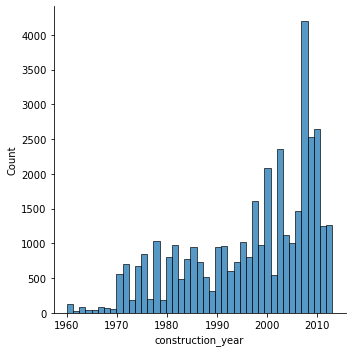

In [242]:
non_null_construction_year = features[features['construction_year'] > 1]

sns.displot(non_null_construction_year, x='construction_year');

- Many wells built around and after 2000

In [243]:
features[['construction_year']].describe().T

,count,mean,std,min,25%,50%,75%,max
construction_year,59400.0,1300.652475,951.620547,0.0,0.0,1986.0,2004.0,2013.0


- Mean (year 1300) is unrealistic. Median (1986) is a much better fill value.

## Add age of well (in years):

In [244]:
# mask for missing construction_year
mask = features['construction_year'].astype(int) == 0

# set construction_year to median (1986) if missing
features.loc[mask, 'construction_year'] = features['construction_year'].median()

# calculate age in years
features['age_years'] = features['date_recorded'].str[:4].astype(int) - features['construction_year']

In [245]:
features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age_years
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,12.0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,3.0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,4.0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,27.0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,1986.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,25.0


## Check for null values in features dataset:

In [246]:
features.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

- 7 of 40 cols have null values
- All 7 cols are of object dtype (strings)

### Add indicator columns before replacing null values:

In [247]:
# add missing indicator cols for the 7 cols from above
null_cols = ['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']

indicator = MissingIndicator()
new_cols = indicator.fit_transform(features)

# create df of the boolean columns
missing_df = pd.DataFrame(new_cols, columns=[col + '_missing' for col in features.columns[indicator.features_]]).astype(int)

features = pd.concat([features, missing_df], axis=1)

In [248]:
features.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age_years,funder_missing,installer_missing,subvillage_missing,public_meeting_missing,scheme_management_missing,scheme_name_missing,permit_missing
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,12.0,0,0,0,0,0,0,0


- 7 new cols were added to indicate the missing values for those cols

### Replace null values:

In [249]:
# replace nulls with 'unknown'
features = features.fillna('unknown')

In [250]:
features.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                   0
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
recorded_by                  0
scheme_management            0
scheme_name                  0
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

# Analyze columns:

In [251]:
features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age_years,funder_missing,installer_missing,subvillage_missing,public_meeting_missing,scheme_management_missing,scheme_name_missing,permit_missing
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,12.0,0,0,0,0,0,0,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,unknown,GeoData Consultants Ltd,Other,unknown,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,3.0,0,0,0,1,0,1,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,4.0,0,0,0,0,0,0,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,unknown,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,27.0,0,0,0,0,0,1,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,unknown,unknown,True,1986.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,25.0,0,0,0,0,1,1,0


### num_private

In [252]:
features['num_private'].describe()

count    59400.000000
mean         0.474141
std         12.236230
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1776.000000
Name: num_private, dtype: float64

In [253]:
features['num_private'].value_counts(normalize=True).head(3)

0    0.987256
6    0.001364
1    0.001229
Name: num_private, dtype: float64

- Going to drop this col, as it has an unclear meaning and the majority (98.7%) of vals are 0.

### extraction_type, extraction_type_group, extraction_type_class

In [254]:
features['extraction_type'].nunique(), features['extraction_type'].unique()

(18,
 array(['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii',
        'other', 'ksb', 'mono', 'windmill', 'afridev', 'other - rope pump',
        'india mark iii', 'other - swn 81', 'other - play pump', 'cemo',
        'climax', 'walimi', 'other - mkulima/shinyanga'], dtype=object))

In [255]:
features['extraction_type_class'].nunique(), features['extraction_type_class'].unique()

(7,
 array(['gravity', 'submersible', 'handpump', 'other', 'motorpump',
        'wind-powered', 'rope pump'], dtype=object))

In [256]:
features['extraction_type_group'].nunique(), features['extraction_type_group'].unique()

(13,
 array(['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii',
        'other', 'mono', 'wind-powered', 'afridev', 'rope pump',
        'india mark iii', 'other handpump', 'other motorpump'],
       dtype=object))

In [257]:
features.groupby(['extraction_type_class', 'extraction_type']).groups.keys()

dict_keys([('gravity', 'gravity'), ('handpump', 'afridev'), ('handpump', 'india mark ii'), ('handpump', 'india mark iii'), ('handpump', 'nira/tanira'), ('handpump', 'other - mkulima/shinyanga'), ('handpump', 'other - play pump'), ('handpump', 'other - swn 81'), ('handpump', 'swn 80'), ('handpump', 'walimi'), ('motorpump', 'cemo'), ('motorpump', 'climax'), ('motorpump', 'mono'), ('other', 'other'), ('rope pump', 'other - rope pump'), ('submersible', 'ksb'), ('submersible', 'submersible'), ('wind-powered', 'windmill')])

- 3 columns describe the type of pump used
- extraction_type seems to hold the most detail with 18 unique values
- dropping the other two may lose a small amount of info, but will reduce collinearity and make model training smoother
- choosing to drop both extraction_type_class and extraction_type_group

### scheme_management and management

In [258]:
features['scheme_management'].nunique(), features['scheme_management'].unique()

(13,
 array(['VWC', 'Other', 'unknown', 'Private operator', 'WUG',
        'Water Board', 'WUA', 'Water authority', 'Company', 'Parastatal',
        'Trust', 'SWC', 'None'], dtype=object))

In [259]:
features['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
unknown              3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [260]:
features['management'].nunique(), features['management'].unique()

(12,
 array(['vwc', 'wug', 'other', 'private operator', 'water board', 'wua',
        'company', 'water authority', 'parastatal', 'unknown',
        'other - school', 'trust'], dtype=object))

In [261]:
features['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

- 2 columns seem to capture the same data. Going to use "management" as it has less unknowns
- Dropping scheme_management

### waterpoint_type, waterpoint_type_group

In [262]:
features['waterpoint_type'].nunique(), features['waterpoint_type'].unique()

(7,
 array(['communal standpipe', 'communal standpipe multiple', 'hand pump',
        'other', 'improved spring', 'cattle trough', 'dam'], dtype=object))

In [263]:
features['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [264]:
features['waterpoint_type_group'].nunique(), features['waterpoint_type_group'].unique()

(6,
 array(['communal standpipe', 'hand pump', 'other', 'improved spring',
        'cattle trough', 'dam'], dtype=object))

In [265]:
features['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

- Dropping waterpoint_type_group as it is slightly less specific than waterpoint_type. It combines the two communal standpipe cats

### source, source_type, source_class	

In [266]:
features['source'].nunique(), features['source'].unique()

(10,
 array(['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other',
        'shallow well', 'river', 'hand dtw', 'lake', 'unknown'],
       dtype=object))

In [267]:
features['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [268]:
features['source_type'].nunique(), features['source_type'].unique()

(7,
 array(['spring', 'rainwater harvesting', 'dam', 'borehole', 'other',
        'shallow well', 'river/lake'], dtype=object))

In [269]:
features['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [270]:
features['source_class'].nunique(), features['source_class'].unique()

(3, array(['groundwater', 'surface', 'unknown'], dtype=object))

In [271]:
features['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

- Dropping source_type. "source" is more specific
- going to keep source_class as it distinguishes above and below ground water sources

### quantity, quantity_group

In [272]:
features['quantity'].nunique(), features['quantity'].unique()

(5,
 array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
       dtype=object))

In [273]:
features['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [274]:
features['quantity_group'].nunique(), features['quantity_group'].unique()

(5,
 array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
       dtype=object))

In [275]:
features['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

- Duplicate columns. Dropping quantity_group

### water_quality, quality_group

In [276]:
features['water_quality'].nunique(), features['water_quality'].unique()

(8,
 array(['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
        'salty abandoned', 'fluoride abandoned'], dtype=object))

In [277]:
features['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [278]:
features['quality_group'].nunique(), features['quality_group'].unique()

(6,
 array(['good', 'salty', 'milky', 'unknown', 'fluoride', 'colored'],
       dtype=object))

In [279]:
features['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

- water_quality seems to be more granular. Dropping quality_group

### payment, payment_type

In [280]:
features['payment'].nunique(), features['payment'].unique()

(7,
 array(['pay annually', 'never pay', 'pay per bucket', 'unknown',
        'pay when scheme fails', 'other', 'pay monthly'], dtype=object))

In [281]:
features['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [282]:
features['payment_type'].nunique(), features['payment_type'].unique()

(7,
 array(['annually', 'never pay', 'per bucket', 'unknown', 'on failure',
        'other', 'monthly'], dtype=object))

In [283]:
features['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

- Duplicate cols. dropping "payment" as it is less succinct

### total static head:
- Change in elevatin between water source and discharge (where water is released). The distance that the water must travel to get from source to output.

In [284]:
features.amount_tsh.to_frame().describe()

,amount_tsh
count,59400.000000
mean,317.650385
std,2997.574558
min,0.000000
25%,0.000000
50%,0.000000
75%,20.000000
max,350000.000000


- lots of TSH of 0. Even the median (50%) value is 0. This could be due to missing values or different pump types
- Standard deviation is massive (almost 10x the mean)

### region and region_code:

In [285]:
features.region.nunique()

21

In [286]:
features.region_code.nunique()

27

In [287]:
features.groupby(['region', 'region_code']).groups.keys()

dict_keys([('Arusha', 2), ('Arusha', 24), ('Dar es Salaam', 7), ('Dodoma', 1), ('Iringa', 11), ('Kagera', 18), ('Kigoma', 16), ('Kilimanjaro', 3), ('Lindi', 8), ('Lindi', 18), ('Lindi', 80), ('Manyara', 21), ('Mara', 20), ('Mbeya', 12), ('Morogoro', 5), ('Mtwara', 9), ('Mtwara', 90), ('Mtwara', 99), ('Mwanza', 17), ('Mwanza', 19), ('Pwani', 6), ('Pwani', 40), ('Pwani', 60), ('Rukwa', 15), ('Ruvuma', 10), ('Shinyanga', 11), ('Shinyanga', 14), ('Shinyanga', 17), ('Singida', 13), ('Tabora', 14), ('Tanga', 4), ('Tanga', 5)])

- 7 regions have multiple codes
- Going to drop "region" when training model as it is redundant and less specific than region code

### Drop 11 redundant columns:

In [288]:
features = features.copy().drop(['date_recorded', 'num_private', 'region', 'scheme_management', 'extraction_type_class', 
                                 'extraction_type_group', 'payment', 'quality_group', 'quantity_group', 'source_type', 
                                 'waterpoint_type_group'], axis=1)

In [289]:
features.shape

(59400, 37)

- 7 missing indicators
- id column
- 29 features

### permit

In [234]:
features['permit'].nunique(), features['permit'].unique()

(3, array([False, True, 'other'], dtype=object))

In [236]:
features['permit'].value_counts(normalize=True)

True     0.654074
False    0.294478
other    0.051448
Name: permit, dtype: float64

- permit is a boolean column

In [ ]:
features.to_csv('')

## Check for null values in labels:

In [11]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


- No nulls

In [12]:
labels.status_group.unique().tolist()

['functional', 'non functional', 'functional needs repair']

### 3 potential targets for water well condition:
- Functional
- Functional, needs repair
- Non-functional

In [13]:
labels.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

### Class proportions are imbalanced:
- "functional" and "non-functional" make up good chunks with 54% and 38% respectively
- the "needs repair" category only makes up 7% of the dataset
- may use SMOTE to upsample this class

## Combine features with labels to view correlations:

In [18]:
# adds 'status_group' col
df = features.merge(labels, on='id')

In [21]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,funder_missing,installer_missing,subvillage_missing,public_meeting_missing,scheme_management_missing,scheme_name_missing,permit_missing,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,0,0,0,0,0,0,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,unknown,GeoData Consultants Ltd,Other,unknown,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,0,0,1,0,1,0,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0,0,0,0,0,0,0,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,unknown,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0,0,0,0,0,1,0,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,unknown,unknown,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,0,0,0,1,1,0,functional


In [19]:
df.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,funder_missing,installer_missing,subvillage_missing,public_meeting_missing,scheme_management_missing,scheme_name_missing,permit_missing
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082,-0.001077,-0.001464,-0.006787,0.003887,-0.005580,0.002329,0.001123
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915,-0.012448,-0.012457,-0.008401,-0.019708,-0.020057,-0.047464,-0.006411
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727,-0.049743,-0.050908,-0.072838,-0.003879,-0.110476,-0.289411,0.071611
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732,0.012071,0.010153,0.029125,-0.098710,-0.005562,-0.174712,0.025430
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278,-0.110021,-0.109258,-0.007765,0.063036,0.019404,0.095259,-0.009980
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056,-0.008418,-0.008451,-0.003072,-0.006544,-0.006023,-0.013349,-0.008009
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724,-0.030869,-0.029878,-0.062260,0.049165,0.123759,0.185578,-0.051857
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315,-0.000424,0.000344,-0.022085,-0.021385,-0.008062,0.107038,-0.064950
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910,-0.056132,-0.056298,-0.027586,0.008573,0.050840,0.044688,0.000395
construction_year,-0.002082,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000,-0.151731,-0.152529,-0.103862,0.020923,-0.010400,-0.237457,-0.010376


In [23]:
features.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age_years
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,12
